## Many Models Batch Training at Scale with Ray Core

This notebook demonstrates yet another example of how to conduct batch training on the [NYC Taxi Dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) 
using only Ray Core and stateless Ray tasks. Because Ray tasks are asynchronous and can be embarrassingly 
parallelized, we will examine two approaches to employ Ray tasks to scale.

<img src="images/nyc_taxi.png" height="80%" width="40%">

One approach is distributed data loading. That is, delegate each independent task to read its respective batch into memory, ensuring that the desired data fits into memory. The second approach is centralized data loading. We preload each data partition once into the Ray object store, and extract each batch per location_id, store it into the Ray object store, from which each task fetches its batch data via object references, albeit at a higher cost of memory to reduce reading and training times. 

This notebook driver uses **Approach 2 (centralized)**: A task per batch loading data from Ray object store



In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from tqdm import tqdm
import mmo_utils as ommt
import matplotlib.pyplot as plt
from pyarrow import dataset as ds
import ray

### Setup an runtime enviroment
Since we are using utils files, they need to be available at each node in the cluster

In [2]:
my_runtime_env = {"working_dir": "."}

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env=my_runtime_env, ignore_reinit_error=True)


2023-01-16 10:44:42,530	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-16 10:44:42,869	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 172.31.182.44:9031...
2023-01-16 10:44:42,902	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_q1w1em4qs2ugkxtq4f1ew76ig3/services?redirect_to=dashboard 
2023-01-16 10:44:42,909	INFO packaging.py:546 -- Creating a file package for local directory '.'.
2023-01-16 10:44:42,914	INFO packaging.py:373 -- Pushing file package 'gcs://_ray_pkg_9a7933122cc5febc.zip' (0.35MiB) to Ray cluster...
2023-01-16 10:44:42,918	INFO packaging.py:386 -- Successfully pushed file package 'gcs://_ray_pkg_9a7933122cc5febc.zip'.


Python version:,3.10.4
Ray version:,2.2.0
Dashboard:,http://console.anyscale.com/api/v2/sessions/ses_q1w1em4qs2ugkxtq4f1ew76ig3/services?redirect_to=dashboard


In [4]:
# Let's read the data as pyarrow table
dataset = ds.dataset(
        "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
        partitioning=["year", "month"],
)

In [5]:
# Let's use three sklearn estimator models
models = [LinearRegression(), 
          DecisionTreeRegressor(),
          DecisionTreeRegressor(splitter="random"),
        ]

# Define batch sizes and tracking list 
all_stats_times = []
# starting_indexes = [-3, -6, -9]
starting_indexes = [-3, -6, -9, -12, -15, -18]

### Iterate through incremental batches of three files

In [6]:
for starting_idx in tqdm(starting_indexes):
    files = [f"s3://anonymous@{file}" for file in tqdm(dataset.files)][starting_idx:]
    print(f"Total files obtained {len(files)}")
    results, time_stats = ommt.run_batch_training_with_object_store(files, models=models)
    all_stats_times.append(time_stats)
    print(f"Sample of results: {results[:-1][0]}")
    print("", flush=True)
    print(f"Total number of pickup locations: {time_stats['total_pickup_locations']}")
    print(f"Total number of pickup locations with enough records to train: {time_stats['total_pickup_locations_trained']}")
    print(f"Total number of models trained: {time_stats['total_models_trained']}")
    print(f"TOTAL TIME TAKEN: {time_stats['total_training_time']} seconds")
    print("--" * 10)

100%|██████████| 18/18 [00:00<00:00, 357807.92it/s]


Total files obtained 3
Starting optimized run: each task fetching pre-loaded data from Ray object store...
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/04/data.parquet/7e490662e39c4bfe8c64c6a2c45c9e8b_000000.parquet', 239, [(DecisionTreeRegressor(splitter='random'), 473.292), (DecisionTreeRegressor(), 473.3), (LinearRegression(), 650.607)])

Total number of pickup locations: 783
Total number of pickup locations with enough records to train: 783
Total number of models trained: 2349
TOTAL TIME TAKEN: 26.877 seconds
--------------------


100%|██████████| 18/18 [00:00<00:00, 315889.00it/s]


Total files obtained 6
Starting optimized run: each task fetching pre-loaded data from Ray object store...
(scheduler +56s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +1m5s) Adding 1 node(s) of type worker-node-type-0.
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2019/01/data.parquet/ecce6478ad09480cbc8539e0b6197c2d_000000.parquet', 151, [(DecisionTreeRegressor(), 485.186), (DecisionTreeRegressor(splitter='random'), 485.278), (LinearRegression(), 652.827)])

Total number of pickup locations: 1568
Total number of pickup locations with enough records to train: 1568
Total number of models trained: 4704
TOTAL TIME TAKEN: 25.566 seconds
--

100%|██████████| 18/18 [00:00<00:00, 405900.39it/s]


Total files obtained 9
Starting optimized run: each task fetching pre-loaded data from Ray object store...
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/10/data.parquet/20624e28db574114b47de3e43065f014_000000.parquet', 68, [(DecisionTreeRegressor(), 571.95), (DecisionTreeRegressor(splitter='random'), 571.974), (LinearRegression(), 718.318)])

Total number of pickup locations: 2355
Total number of pickup locations with enough records to train: 2355
Total number of models trained: 7065
TOTAL TIME TAKEN: 31.278 seconds
--------------------


100%|██████████| 18/18 [00:00<00:00, 233016.89it/s]


Total files obtained 12
Starting optimized run: each task fetching pre-loaded data from Ray object store...
(scheduler +2m2s) Resized to 80 CPUs.
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 145, [(DecisionTreeRegressor(splitter='random'), 444.14), (DecisionTreeRegressor(), 444.306), (LinearRegression(), 643.518)])

Total number of pickup locations: 3137
Total number of pickup locations with enough records to train: 3137
Total number of models trained: 9411
TOTAL TIME TAKEN: 31.471 seconds
--------------------


100%|██████████| 18/18 [00:00<00:00, 301989.89it/s]


Total files obtained 15
Starting optimized run: each task fetching pre-loaded data from Ray object store...
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 145, [(DecisionTreeRegressor(splitter='random'), 426.113), (DecisionTreeRegressor(), 426.401), (LinearRegression(), 649.42)])

Total number of pickup locations: 3918
Total number of pickup locations with enough records to train: 3918
Total number of models trained: 11754
TOTAL TIME TAKEN: 35.884 seconds
--------------------


100%|██████████| 18/18 [00:00<00:00, 318554.73it/s]


Total files obtained 18
Starting optimized run: each task fetching pre-loaded data from Ray object store...
Sample of results: ('s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 41, [(DecisionTreeRegressor(), 444.671), (DecisionTreeRegressor(splitter='random'), 444.807), (LinearRegression(), 567.213)])

Total number of pickup locations: 4700
Total number of pickup locations with enough records to train: 4700
Total number of models trained: 14100
TOTAL TIME TAKEN: 35.283 seconds
--------------------


100%|██████████| 6/6 [03:06<00:00, 31.12s/it]


### Plot all the collected training times and relevant batch data

In [7]:
#  Print all cumulative results and stats
# all_stats_times_df = pd.DataFrame(all_stats_times, index=[3, 6, 9])
all_stats_times_df = pd.DataFrame(all_stats_times, index=[3, 6, 9, 12, 15, 18])
display(all_stats_times_df)

,total_pickup_locations,total_pickup_locations_trained,total_models_trained,total_training_time
3,783,783,2349,26.877
6,1568,1568,4704,25.566
9,2355,2355,7065,31.278
12,3137,3137,9411,31.471
15,3918,3918,11754,35.884
18,4700,4700,14100,35.283


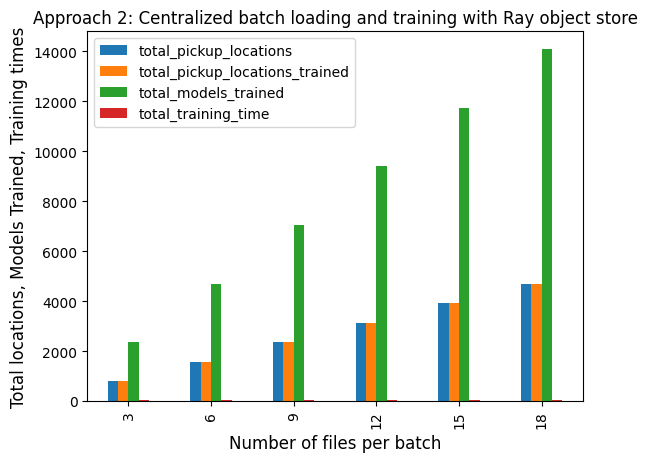

(scheduler +8m32s) Removing 1 nodes of type worker-node-type-0 (idle).
(scheduler +8m50s) Resized to 64 CPUs.


In [8]:
# Plot some times
all_stats_times_df.plot(kind="bar")

plt.ylabel("Total locations, Models Trained, Training times", fontsize=12)
plt.xlabel("Number of files per batch", fontsize=12)
plt.title("Approach 2: Centralized batch loading and training with Ray object store")

plt.grid(False)
plt.show()

In [11]:
ray.shutdown()